Test

In [16]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os
from matplotlib.lines import Line2D



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#from sklearn.linear_model import LogisticRegression
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.naive_bayes import GaussianNB
#from sklearn.metrics import confusion_matrix
#from sklearn.decomposition import PCA
#from matplotlib.colors import ListedColormap
#from sklearn.metrics import accuracy_score

from scipy import sparse

directory = os.getcwd()
#set path for input DATA
data_path = os.path.join(directory, "data")
print(data_path)


artists_file = os.path.join(data_path, "artists.dat")
artists_spotify_file = os.path.join(data_path, "data_by_artist_o.csv")
tag_file = os.path.join(data_path, "tags.dat")
users_artists_file = os.path.join(data_path, "user_artists.dat")
users_tags_file = os.path.join(data_path, "user_taggedartists.dat")


/Users/luis/Documents/21_ISYE6740_CDA/Project/cda_recomm_project/data


In [340]:
#import data
artists_spotify_data = pd.read_csv(artists_spotify_file)
print("artists_spotify_data shape: ",artists_spotify_data.shape)

artists_data = pd.read_csv(artists_file,sep="\t")
print("artists_data shape: ",artists_data.shape)

tag_data = pd.read_csv(tag_file,sep="\t",encoding='latin-1')
print("tag_data shape: ",tag_data.shape)


users_artists_data = pd.read_csv(users_artists_file,sep="\t")
print("users_artists_data shape: ",users_artists_data.shape)


users_tags_data = pd.read_csv(users_tags_file,sep="\t")
print("users_tags_data shape: ",users_tags_data.shape)


artists_spotify_data shape:  (28680, 16)
artists_data shape:  (17632, 4)
tag_data shape:  (11946, 2)
users_artists_data shape:  (92834, 3)
users_tags_data shape:  (186479, 6)


In [168]:
#functions from "Procesing Functions Notebook"

#remove weights outside of thresholds 
#Avoids issues with uncommon listening habits. 
#i.e: users that have played artist over 100k times
def remove_extreme_weights (df,min_weight,max_weight):
    '''
    Requires input dataframe with userID, artistID, weight columns
    min_weight = min # times a user must have played an aritst to keep the record
    max_weight = max # times a user must have played an aritst to keep the record
    '''    
    print('df original shape: ',df.shape)    
    sns.boxplot(y="weight", data=df)
    plt.title('Boxplot - Original Data')
    plt.show()
    
    bin_data = df.copy()
    labels = ['a.<10','b.10-1K','c.1K-5K','d.5K-10K','e.10K-20K','f.20K-50K','g.50K-100K','h.+100K']
    bins = [0, 10,1000,5000,10000,20000,50000,100000, np.inf]
    bin_data['weight_bin'] = pd.cut(bin_data['weight'], bins,labels=labels)
    print('original data binned:')
    print(bin_data['weight_bin'].value_counts(sort=False))
    print('\n')

    filtered_df = df[df['weight'].between(min_weight, max_weight)].reset_index(drop=True)
    print('df new shape: ',filtered_df.shape)
    sns.boxplot(y="weight", data=filtered_df)
    plt.title('Boxplot - Filtered Data')
    plt.show()
    print('filtered data - stats:')
    print(filtered_df['weight'].describe())
    print('\n')
    print(f"% of removed records: {round(1-(filtered_df.shape[0]/df.shape[0]),4)}")
    
    return filtered_df

#remove users with low artist count. 
#Avoid issues if user only listens to 1 artist
def remove_users_lowcount (df,min_artists):
    '''
    Requires input dataframe with userID, artistID, weight columns
    min_artists = minimum number of artists a user must have listened to
    '''    
    print('df original shape: ',df.shape)
    print('unique users: ',df['userID'].nunique())

    grouped_df = df.groupby('userID', dropna=False).agg({'artistID':['count']})
    grouped_df = grouped_df.droplevel(axis=1, level=0)
    users_drop = grouped_df[grouped_df['count'] < min_artists].index

    print(f"users with less than {min_artists} artists: {len(users_drop)}")

    new_df = df[~df['userID'].isin(users_drop)].reset_index(drop=True)

    print('unique users after removal: ',new_df['userID'].nunique())
    print('df new shape: ',new_df.shape)
    print(f"% of removed records: {round(1-(new_df.shape[0]/df.shape[0]),4)}")
    return new_df


#source: https://github.com/statisticianinstilettos/recmetrics/blob/master/recmetrics/plots.py 

def long_tail_plot(df, item_id_column, percentage=0.75):
    """
    Plots the long tail for a user-item interaction dataset.
    ----------
    df: pandas dataframe
        user-item interaction dataframe
        example:
    item_id_column: str
        column name identifying the item ids in the dataframe
    percentage: float, default=None
        percent of volume to consider as the head (percent as a decimal)
        (if default=None no line will be plotted)

    Returns:
    -------
        A long tail plot
    """
    volume_df = df[item_id_column].value_counts().reset_index()
    volume_df.columns = [item_id_column, "volume"]
    volume_df[item_id_column] = volume_df[item_id_column].astype(str)
    volume_df['cumulative_volume'] = volume_df['volume'].cumsum()
    volume_df['percent_of_total_volume'] = volume_df['cumulative_volume']/volume_df['volume'].sum()
    
    #line plot of cumulative volume
    ax=sns.lineplot(x = 'index', y="volume", data=volume_df.reset_index(), color="black")
    #set labels
    ax.set_title('Long Tail Plot of User weights by Artist')
    ax.set_ylabel('# of user weights')
    ax.set_xlabel(item_id_column)
    plt.tick_params(labelbottom = False)
    
    #plot vertical line at the tail location
    head = volume_df[volume_df["percent_of_total_volume"] <= percentage]
    tail = volume_df[volume_df["percent_of_total_volume"] > percentage]
    items_in_head = len(head)
    items_in_tail = len(tail)
    plt.axvline(x=items_in_head, color="red",  linestyle='--')

    # fill area under plot
    head = head.append(tail.head(1))
    x1 = head.index.values
    y1 = head['volume']
    x2 = tail.index.values
    y2 = tail['volume']
    ax.fill_between(x1, y1, color="blue", alpha=0.2)
    ax.fill_between(x2, y2,  color="orange", alpha=0.2)

    #create legend
    legend_elements = [Line2D([0], [0], marker='o', color='w', label=str(items_in_head)+': artists in the head', markerfacecolor='blue', markersize=5),
                       Line2D([0], [0], marker='o', color='w', label=str(items_in_tail)+': artists in the tail', markerfacecolor='orange', markersize=5)]
    ax.legend(handles=legend_elements, loc=1)

    plt.show()
    
def remove_popular_artists(df,artist_df,pct_remove):
    '''
    Requires input dataframe with [userID, artistID, weight] columns
    Requires lastfm artist input dataframe with [id, name] columns
    pct_remove: pct of top artists to remove. Example: 0.01 removes the top 1% artists with
    top count of users (popular)
    Dont filter if your algorithm will already take care of this artist-level bias
    '''  
    #input dataset info
    print(f"input data shape: {df.shape}")
    print('unique artists: ',df['artistID'].nunique())

    artists_group = df.groupby('artistID').agg({'weight': ['count']})
    artists_group = artists_group.droplevel(axis=1, level=0)
    artists_group = artists_group.sort_values(by='count',ascending=False)

    #artists_group['artist']=range(0,artists_group.shape[0])
    #ax = sns.lineplot(x = 'artist', y='count', data=artists_group)
    #plt.tick_params(labelbottom = False)
    #plt.title('Long tail distribution of tot Users per Artist')
    #plt.ylabel('count of users')
    #plt.show()
    pct_plot = 0.8
    print(f"line divides top: {pct_plot*100} % cumulative sum of users:") 
    long_tail_plot(df,'artistID',0.8)
    
    top_list = artists_group.head(10).index
    print('top 10 artists (most users): ')
    print(artist_df[artist_df['id'].isin(top_list)]['name'])
    print('\n')

    #filter dataset
    threshold = artists_group['count'].quantile(1-pct_remove) #percentile
    removed_artists = artists_group[artists_group['count'] > threshold].index
    filtered_df = df[~df['artistID'].isin(removed_artists)].reset_index(drop=True)
    num_removed = len(removed_artists)
    print(f"total removed artists: {num_removed}") 

    #new dataset info
    artists_group = filtered_df.groupby('artistID').agg({'weight': ['count']})
    artists_group = artists_group.droplevel(axis=1, level=0)
    artists_group = artists_group.sort_values(by='count',ascending=False)
    
    #artists_group['artist']=range(0,artists_group.shape[0])
    #ax = sns.lineplot(x = 'artist', y='count', data=artists_group)
    #plt.tick_params(labelbottom = False)
    #plt.title('Distribution of tot Users per Artist - Filtered Dataset')
    #plt.ylabel('count of users')
    #plt.show()
    print('\n')
    print(f"line divides top: {pct_plot*100} % cumulative sum of users:") 
    long_tail_plot(filtered_df,'artistID',pct_plot)
    
    top_list = artists_group.head(10).index
    print('top 10 artists (most users) - filtered dataset: ')
    print(artist_df[artist_df['id'].isin(top_list)]['name'])
    
    print('\n')
    print(f"filtered dataset shape: {filtered_df.shape}") 
    print('unique artists after removal: ',filtered_df['artistID'].nunique())
    print(f"% of removed records: {round(1-(filtered_df.shape[0]/df.shape[0]),4)}")


    return filtered_df
def remove_rare_artists(df,artist_df,min_users):
    '''
    Requires input dataframe with [userID, artistID, weight] columns
    Requires lastfm artist input dataframe with [id, name] columns
    min_users: minimum number of users each artist must have 
    Dont filter if your algorithm will already take care of this artist-level bias
    '''  
    #input dataset info
    print(f"input data shape: {df.shape}")
    print('unique artists: ',df['artistID'].nunique())

    artists_group = df.groupby('artistID').agg({'weight': ['count']})
    artists_group = artists_group.droplevel(axis=1, level=0)
    artists_group = artists_group.sort_values(by='count',ascending=False)
    
    pct_plot = 0.8
    print(f"line divides top: {pct_plot*100} % cumulative sum of users:") 
    long_tail_plot(df,'artistID',0.8)
    #artists_group['artist']=range(0,artists_group.shape[0])
    #ax = sns.lineplot(x = 'artist', y='count', data=artists_group)
    #plt.tick_params(labelbottom = False)
    #plt.title('Long tail distribution of User count by Artist')
    #plt.ylabel('count of users')
    #plt.show()
    
    top_list = artists_group.tail(10).index
    print('bottom 10 artists: ')
    print(artist_df[artist_df['id'].isin(top_list)]['name'])
    print('\n')

    #filter dataset
    #threshold = artists_group['count'].quantile(pct_remove) #percentile
    removed_artists = artists_group[artists_group['count'] < min_users].index
    filtered_df = df[~df['artistID'].isin(removed_artists)].reset_index(drop=True)
    num_removed = len(removed_artists)
    print(f"total removed artists: {num_removed}") 

    #new dataset info
    artists_group = filtered_df.groupby('artistID').agg({'weight': ['count']})
    artists_group = artists_group.droplevel(axis=1, level=0)
    artists_group = artists_group.sort_values(by='count',ascending=False)
    
    #artists_group['artist']=range(0,artists_group.shape[0])
    #ax = sns.lineplot(x = 'artist', y='count', data=artists_group)
    #plt.tick_params(labelbottom = False)
    #plt.title('Long tail distribution of User count by Artist')
    #plt.ylabel('count of users')
    #plt.show()
    print('\n')
    print(f"line divides top: {pct_plot*100} % cumulative sum of users:") 
    long_tail_plot(filtered_df,'artistID',0.8)
    
    top_list = artists_group.tail(10).index
    print('bottom 10 artists - filtered dataset: ')
    print(artist_df[artist_df['id'].isin(top_list)]['name'])
    
    print('\n')
    print(f"filtered dataset shape: {filtered_df.shape}") 
    print('unique artists after removal: ',filtered_df['artistID'].nunique())
    print(f"% of removed records: {round(1-(filtered_df.shape[0]/df.shape[0]),4)}")


    return filtered_df

#scale weights at user level
#2 users might have a favorite artist, user 1 played such artist 100k times
#user 2 played such artist 10k times. However those users are still neighbors
#dont scale if your algorithm will already take care of this user-level bias

def scale_weight_by_user(df):
    '''
    Requires input dataframe with userID, artistID, weight columns
    Dont scale if your algorithm will already take care of this user-level bias
    '''  
    print('df original shape: ',df.shape)    
    sns.boxplot(y="weight", data=df)
    plt.title('Boxplot - Original Data')
    plt.show()
    
    scaled_df = df.copy()
    scaled_df['weight'] = scaled_df.groupby('userID')['weight'].apply(lambda x: (x-x.min())/(x.max()-x.min()))
    
    #adding 0.01 to provent 0 values
    scaled_df['weight'] = scaled_df['weight'] + 0.01
    #to handle 0 division
    scaled_df['weight'] = scaled_df['weight'].fillna(0.5)

    print('df scaled shape: ',scaled_df.shape)    
    sns.boxplot(y="weight", data=scaled_df)
    plt.title('Boxplot - Scaled Data')
    plt.show()
    
    return scaled_df

def train_test_split(df,sample_size,seed=1):
    '''
    Requires input dataframe with userID, artistID, weight columns
    sample_size = number of artists per user to sample for test set
    
    sample_size must be smaller than total artist count per user!!!
    
    '''  
    print(f"input data shape: {df.shape}")
    
    np.random.seed(seed)
    sample = df.groupby('userID').apply(lambda x: x.sample(sample_size))
    sample_index = list(sample.index.get_level_values(1))
 
    train  = df[~df.index.isin(sample_index)]
    train.reset_index(drop=True,inplace=True)
    print(f"train set shape: {train.shape}")

    test  = df[df.index.isin(sample_index)]
    test.reset_index(drop=True,inplace=True)
    print(f"test set shape: {test.shape}")
    print('\n')
    #all test artists must be part of the training data
    unique_train = train['artistID'].unique()
    unique_test = test['artistID'].unique()
    diff = np.setdiff1d(unique_test,unique_train)
    if len(diff)>1:
        print(f"WARNING: {len(diff)} artists from the test set are not on the train set")
        print('1.consider increasing the min count of users per artist when pre-processing')
        print('2.consider decreasing the number of samples per user for train-test split')
        print('3.as al ast resource consider changing your seed')
    else:
        print('OK: all artists from the test set are part on the train set as well')
    return train, test

In [169]:
#listening habits of artists. Weight = scrobbles = plays
users_artists_data.head()

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


In [170]:
#How many unique users?
len(pd.unique(users_artists_data['userID']))

1892

In [171]:
#How many unique artists?
len(pd.unique(users_artists_data['artistID']))

17632

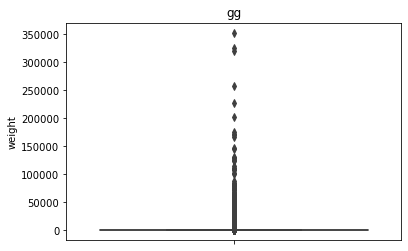

In [172]:
sns.boxplot(y="weight", data=users_artists_data)
plt.title('gg')
plt.show()

In [82]:
#what are the chances a human being played a 4 min song 350K times?
#suppose the person played the artist 20 times a day
#How many years did they play the artist at that rate:
350000/20/360

#not reasonable unless you're a rigged radio station. 

48.611111111111114

In [89]:
#is 5K beliveable
5000/20/360

0.6944444444444444

In [757]:
df_scrobbles = users_artists_data.merge(artists_data[['id','name']],
                               how = 'inner',
                               left_on = 'artistID',
                               right_on = 'id')


df_scrobbles = df_scrobbles.drop(columns=['id'])
df_scrobbles.columns = ['userID','artistID','scrobbles','name']

print(df_scrobbles.shape)
df_scrobbles.head()

(92834, 4)


,userID,artistID,scrobbles,name
0,2,51,13883,Duran Duran
1,4,51,228,Duran Duran
2,27,51,85,Duran Duran
3,28,51,10,Duran Duran
4,62,51,528,Duran Duran


In [758]:
#Merging some tables 
df_scrobbles = users_artists_data.merge(artists_data[['id','name']],
                               how = 'inner',
                               left_on = 'artistID',
                               right_on = 'id')


df_scrobbles = df_scrobbles.drop(columns=['id'])
df_scrobbles.columns = ['userID','artistID','scrobbles','name']

print(df_scrobbles.shape)
#df_scrobbles.head()


grouped_df = df_scrobbles.groupby('artistID', dropna=False).agg({'weight':['sum']})
grouped_df

(92834, 4)


KeyError: "Column 'weight' does not exist!"

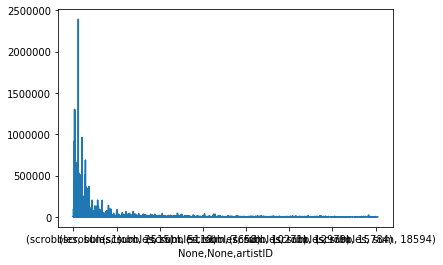

In [12]:
#Scrobble Distribution by artists:
artists_group = df_scrobbles.groupby('artistID').agg({'scrobbles': ['sum']})

artists_group.unstack().plot()
plt.show()

#Recommending popular artaists may not offer a personalized experience
#but models might learn a lot about that data because they show up in so many samples



In [13]:
#Potential Risk
#some users play lots of music. suppose their top artist was playe 10,000 times. 
#other users might be similar in preferences, with the same top artist, but with only 100 plays
#CAN WE NORMALIZE AT USER LEVEL? 
scrobbles_sorted = df_scrobbles.groupby('userID').agg({'scrobbles': ['min', 
                                                                  'max',
                                                                  'sum',
                                                                  'count']})

scrobbles_sorted
#for example. For userID 2: 13,383 represents their top artist
#for userID 6: 1,011 represet their top artist. If both top artists are Duran Duran
#then the data points wont be as close to each other when maybe they should???
#but if we scale the whole dataset the problem will remain suppose 13,383 gets converted
#to 1.383 and 1,011 gets converted to 0.101. 






scrobbles                     
             min    max     sum count
userID                               
2           1315  13883  168737    50
3             65  13176   20501    50
4            193   4983   26930    50
5            115    884   13159    50
6             13     41    1011    50
...          ...    ...     ...   ...
2095          31    548    4885    50
2096         336  14690   62714    50
2097         107   2628   13830    50
2099          72    770   10179    50
2100         228   2026   30877    50

[1892 rows x 4 columns]

df original shape:  (92834, 3)


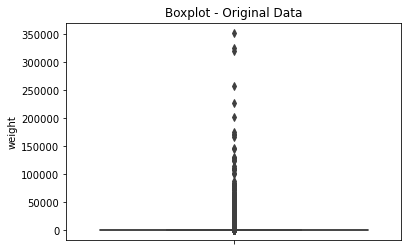

original data binned:
a.<10          3461
b.10-1K       75313
c.1K-5K       12509
d.5K-10K        921
e.10K-20K       380
f.20K-50K       188
g.50K-100K       37
h.+100K          25
Name: weight_bin, dtype: int64


df new shape:  (90647, 3)


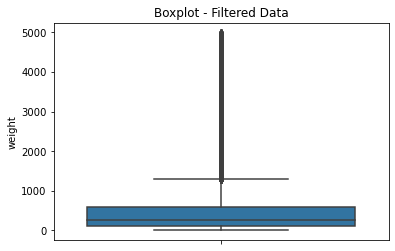

filtered data - stats:
count   90647.000
mean      503.311
std       694.295
min         2.000
25%       107.000
50%       256.000
75%       587.000
max      4991.000
Name: weight, dtype: float64


% of removed records: 0.0236
input data shape: (90647, 3)
unique artists:  17453
line divides top: 80.0 % cumulative sum of users:


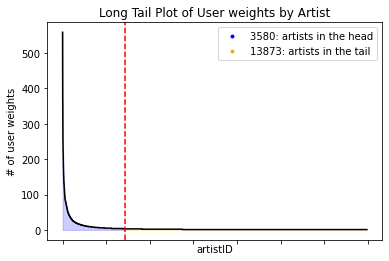

top 10 artists (most users): 
61            Madonna
83          Lady Gaga
148         Radiohead
184              Muse
221       The Beatles
282           Rihanna
283    Britney Spears
289           Beyoncé
294        Katy Perry
327     Avril Lavigne
Name: name, dtype: object


total removed artists: 83


line divides top: 80.0 % cumulative sum of users:


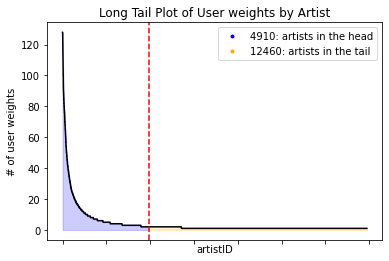

top 10 artists (most users) - filtered dataset: 
176                  Keane
193            Arcade Fire
219               Interpol
310      Alanis Morissette
346            Cheryl Cole
419        Yeah Yeah Yeahs
534           Fall Out Boy
729     The Rolling Stones
1039             The Kooks
1919                 Adele
Name: name, dtype: object


filtered dataset shape: (71646, 3)
unique artists after removal:  17370
% of removed records: 0.2096
input data shape: (71646, 3)
unique artists:  17370
line divides top: 80.0 % cumulative sum of users:


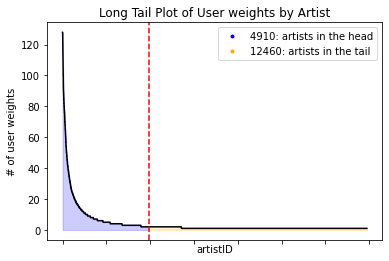

bottom 10 artists: 
9085             A.C. Newman
9087               The Muffs
9089     Sigue Sigue Sputnik
9090            T3CHN0PH0B1A
9091           Ian McCulloch
9092                Michigan
9093            Jason Ferris
9094        Myrmidon Process
9095           The Hannibals
17631       Grzegorz Tomczak
Name: name, dtype: object


total removed artists: 14656


line divides top: 80.0 % cumulative sum of users:


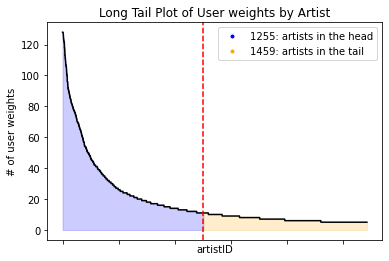

bottom 10 artists - filtered dataset: 
1287                  Seabound
1306                Wynardtage
1823                      Chic
2951        Animals as Leaders
4482    www.djrobsonmichel.com
4503                 dead prez
6312               Anna Nalick
6319                I Am Ghost
6330                    Djavan
6392                      2ois
Name: name, dtype: object


filtered dataset shape: (50487, 3)
unique artists after removal:  2714
% of removed records: 0.2953


df original shape:  (50487, 3)
unique users:  1873
users with less than 10 artists: 63
unique users after removal:  1810
df new shape:  (50199, 3)
% of removed records: 0.0057
input data shape: (50199, 3)
train set shape: (46579, 3)
test set shape: (3620, 3)


OK: all artists from the test set are part on the train set as well


In [731]:
#Suppose we apply all the preprocessing steps. except for scaling
df_excl_extremes = remove_extreme_weights (users_artists_data,2,5000)
df_excl_popular = remove_popular_artists (df_excl_extremes,artists_data,0.005)
df_excl_rare = remove_rare_artists (df_excl_popular,artists_data,min_users = 5)
print('\n')
df_excl_users_low = remove_users_lowcount(df_excl_rare,10)
#df_scaled = scale_weight_by_user (df_excl_users_low)
#remove 2 artists per use for testing:
train, test = train_test_split(df_excl_users_low,sample_size=2,seed=2021)





In [732]:
#Sparse matrix, we need to pivot the data
data_pivot = train.pivot(index='userID',
                                       columns='artistID').fillna(0).astype(int)
data_pivot.head()

weight                                                        ...  \
artistID  2     6     8     9     10    11    12    13    15    16     ...   
userID                                                                 ...   
2             0     0     0     0     0     0     0     0     0     0  ...   
4             0     0     0     0     0     0     0     0     0     0  ...   
5             0     0     0     0     0     0     0     0     0     0  ...   
6             0     0     0     0     0     0     0     0     0     0  ...   
7             0     0     0     0     0     0     0     0     0     0  ...   

                                                                      
artistID 12406 12555 12599 12868 12918 13292 13303 13888 14645 14692  
userID                                                                
2            0     0     0     0     0     0     0     0     0     0  
4            0     0     0     0     0     0     0     0     0     0  
5            0     0     0     0     0     0     0     0     0     0  
6            0     0     0     0     0     0     0     0     0     0  
7            0     0     0     0     0     0     0     0     0     0  

[5 rows x 2714 columns]

In [733]:
sparsity = float(len(data_pivot.values.nonzero()[0]))
sparsity /= (data_pivot.shape[0] * data_pivot.shape[1])
sparsity *= 100
print ('Sparsity: {:4.2f}%'.format(sparsity))
#0.03% of the matrix has a value

Sparsity: 0.95%


In [179]:
#Trying to make it more memory efficient
# create scipy sparse from pivot tables
data_sparse = sparse.csr_matrix(data_pivot)
data_sparse.shape

(1810, 2714)

In [456]:
#show top 5 per user

#Merging some tables 
df_scrobbles = users_artists_data.merge(artists_data[['id','name']],
                                        how = 'inner',
                                        left_on = 'artistID',
                                        right_on = 'id')


df_scrobbles = df_scrobbles.drop(columns=['id'])
df_scrobbles.columns = ['userID','artistID','weight','name']

print(df_scrobbles.shape)

def get_top_artists(user_id,n=5):
    top_list = df_scrobbles[df_scrobbles['userID']==user_id].sort_values(by='weight')['name'].head(n)      
    return list(top_list)
    


(92834, 4)


In [436]:
#show top 5 per user

#Merging some tables 
df_scrobbles = users_artists_data.merge(artists_data[['id','name']],
                                        how = 'inner',
                                        left_on = 'artistID',
                                        right_on = 'id')


df_scrobbles = df_scrobbles.drop(columns=['id'])
df_scrobbles.columns = ['userID','artistID','weight','name']

In [449]:
list(df_scrobbles[df_scrobbles['userID']==2].sort_values(by='weight')['name'].head(5))

['ABC', 'INXS', 'Japan', 'Duffy', 'Fleetwood Mac']

In [462]:
get_top_artists(901,5)

[]

## Colaborative Filtering

In [139]:
#cosine similarity function
#source: https://www.ethanrosenthal.com/2015/11/02/intro-to-collaborative-filtering/
def similarity(ratings, kind='user', epsilon=1e-9):
    '''
    For user-based collaborative filtering, the user-similarity matrix will consist 
    of some distance metric that measures the similarity between any two pairs of users.
    Likewise, the item-similarity matrix will measure the similarity between any 
    two pairs of items.
    '''
    # epsilon -> small number for handling dived-by-zero errors
    if kind == 'user':
        sim = ratings.dot(ratings.T) + epsilon
    elif kind == 'item':
        sim = ratings.T.dot(ratings) + epsilon
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)

In [121]:
'''
For user-based collaborative filtering, we predict that a user’s u's rating for item 
i is given by the weighted sum of all other users’ ratings for item i
where the weighting is the cosine similarity between the each user and the input user u
We must also normalize by the number of ratings
'''

def collab_filtering_predict(ratings, similarity, kind='user'):
    if kind == 'user':
        return similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif kind == 'item':
        return ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])

def test_set_to_matrix(train,test):
    '''
    test set might not include all artists, so those rows are aded with weight zero
    '''
    unique_train = train['artistID'].unique()
    unique_test = test['artistID'].unique()
    
    random_user = test['artistID'].head(1)
    users = np.repeat(random_user,len(diff))
    diff_artists = np.setdiff1d(unique_train,unique_test) #artists not on test set
    weights = np.zeros(len(diff))
    
    df = pd.DataFrame(list(zip(users,diff_artists,weights))
                 ,columns = ['userID','artistID','weight'])
    
    df = test.append(df)    
    df = df.pivot(index='userID',columns='artistID').fillna(0).astype(int)
    print(f"test pivot matrix shape: {df.shape}")
    return df
    
from sklearn.metrics import mean_squared_error
def get_rmse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)**0.5 

In [734]:
data_pivot

weight                                                        ...  \
artistID  2     6     8     9     10    11    12    13    15    16     ...   
userID                                                                 ...   
2             0     0     0     0     0     0     0     0     0     0  ...   
4             0     0     0     0     0     0     0     0     0     0  ...   
5             0     0     0     0     0     0     0     0     0     0  ...   
6             0     0     0     0     0     0     0     0     0     0  ...   
7             0     0     0     0     0     0     0     0     0     0  ...   
...         ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
2094          0     0     0     0     0     0     0     0     0     0  ...   
2096          0     0     0     0     0     0     0     0     0     0  ...   
2097          0     0     0     0     0     0     0     0     0     0  ...   
2099          0     0     0     0     0     0     0     0     0     0  ...   
2100          0     0     0     0     0     0  1253     0     0     0  ...   

                                                                      
artistID 12406 12555 12599 12868 12918 13292 13303 13888 14645 14692  
userID                                                                
2            0     0     0     0     0     0     0     0     0     0  
4            0     0     0     0     0     0     0     0     0     0  
5            0     0     0     0     0     0     0     0     0     0  
6            0     0     0     0     0     0     0     0     0     0  
7            0     0     0     0     0     0     0     0     0     0  
...        ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
2094         0     0     0     0     0     0     0     0     0     0  
2096         0     0     0     0     0     0     0     0     0     0  
2097         0     0     0     0   109     0     0     0     0     0  
2099         0     0     0   118     0     0     0     0     0     0  
2100         0     0     0     0     0     0     0     0     0     0  

[1810 rows x 2714 columns]

In [735]:
#fit model = generate cosine matrix for the train set
cosine_matrix = similarity(data_pivot,kind='user')


In [736]:
cosine_matrix

userID,2,4,5,6,7,8,9,10,11,12,...,2088,2090,2091,2092,2093,2094,2096,2097,2099,2100
userID,,,,,,,,,,,,,,,,,,,,,
2,1.000,0.080,0.000,0.022,0.000,0.016,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.011,0.000,0.007,0.028,0.000,0.000
4,0.080,1.000,0.036,0.017,0.000,0.000,0.000,0.000,0.000,0.036,...,0.010,0.000,0.000,0.000,0.013,0.000,0.017,0.000,0.000,0.000
5,0.000,0.036,1.000,0.000,0.000,0.000,0.000,0.253,0.000,0.000,...,0.000,0.000,0.000,0.285,0.000,0.000,0.168,0.073,0.000,0.000
6,0.022,0.017,0.000,1.000,0.000,0.060,0.000,0.000,0.000,0.000,...,0.057,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
7,0.000,0.000,0.000,0.000,1.000,0.198,0.000,0.000,0.054,0.000,...,0.108,0.000,0.017,0.000,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2094,0.000,0.000,0.000,0.000,0.000,0.088,0.092,0.000,0.055,0.000,...,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000
2096,0.007,0.017,0.168,0.000,0.000,0.000,0.000,0.000,0.000,0.029,...,0.008,0.000,0.000,0.040,0.020,0.000,1.000,0.076,0.000,0.000
2097,0.028,0.000,0.073,0.000,0.000,0.000,0.000,0.178,0.000,0.000,...,0.000,0.000,0.052,0.161,0.000,0.000,0.076,1.000,0.000,0.000


In [676]:
cosine_matrix[cosine_matrix.index==2013]

userID,2,4,5,6,7,8,9,10,11,12,...,2088,2090,2091,2092,2093,2094,2096,2097,2099,2100
userID,,,,,,,,,,,,,,,,,,,,,
2013,0.000,0.025,0.157,0.000,0.000,0.000,0.000,0.015,0.000,0.000,...,0.000,0.000,0.000,0.124,0.000,0.000,0.046,0.073,0.000,0.030


In [677]:
data_pivot[data_pivot.index==2013]

weight                                                        ...  \
artistID  2     6     8     9     10    11    12    13    15    16     ...   
userID                                                                 ...   
2013          0     0     0     0     0     0     0     0     0     0  ...   

                                                                      
artistID 12406 12555 12599 12868 12918 13292 13303 13888 14645 14692  
userID                                                                
2013         0     0     0     0     0     0     0     0     0     0  

[1 rows x 2714 columns]

In [738]:
#Basic Qualitative Testing using the matrix
user = np.random.choice(cosine_matrix.index)#pick a row from train matrix
n_neighbors = 5

table = cosine_matrix.reset_index()
user_row = table[table['userID']==user] #pick user row
user_row = user_row.iloc[: , 1:].transpose() #drop first column and transpose
user_row.columns=['distance']
user_row = user_row.sort_values(by='distance',ascending=False) #higher is closer

neighbors = list(user_row.head(n_neighbors+1).index)
distances = list(user_row['distance'].head(n_neighbors+1))

top_artists = get_top_artists(user,5)
print(f"Neighbors for user {user}\ntop 5: {top_artists}\n")

for i in range(1,n_neighbors+1):
        top_artists = get_top_artists(neighbors[i],5)
        print(f"{i}: User {neighbors[i]} \n distance {distances[i]}\n top artists: {top_artists}\n")



Neighbors for user 233
top 5: ['GAGA', 'Greyson Chance', 'T.I.', 'Dougie Poynter', 'Shareefa']

1: User 538 
 distance 0.29406203942033954
 top artists: ['Alexandra Burke', 'Nelly Furtado', 'Ashlee Simpson', 'Carrie Underwood', 'Willow Smith']

2: User 768 
 distance 0.2891360180727891
 top artists: ['The Cranberries', 'Parachute', "Disney's Friends For Change", 'Selena Gomez & Demi Lovato', 'Corbin Bleu']

3: User 1590 
 distance 0.2717105749039754
 top artists: ['Keri Hilson', 'Black Eyed Peas', 'Space Cowboy', 'Annie', 'Young Love']

4: User 55 
 distance 0.26863463727709097
 top artists: ['The Game', 'GZA/Genius', 'Jimi Hendrix', 'Pac Div', 'The Grouch & Eligh']

5: User 322 
 distance 0.26458215351835795
 top artists: ['Emily Osment', 'Yolanda Be Cool & DCUP', 'David Guetta', 'Tinchy Stryder', 'Jay-Z']



In [743]:
recommend_knn(user,10,10)

computed scores:  2713
scores higher than 0:  153
scores for unknown artists:  147


,artistID,weight,name
111,1935,1151.314,Solange
70,1038,1034.240,The Maine
5,156,828.820,VAST
118,2247,821.725,Dr. Dre
135,4565,728.334,Doda
43,528,670.506,Pixie Lott
144,5688,646.797,Heaven & Hell
42,527,635.249,Lil' Wayne
117,2097,628.676,Brown Eyed Girls
127,3503,582.038,Tarkan


In [741]:
recommend_knn(user,5,10)

computed scores:  2713
scores higher than 0:  86
scores for unknown artists:  83


,artistID,weight,name
40,1038,1034.240,The Maine
70,2247,821.725,Dr. Dre
78,4565,728.334,Doda
20,527,706.170,Lil' Wayne
74,3503,688.707,Tarkan
21,528,670.506,Pixie Lott
83,5688,646.797,Heaven & Hell
5,286,481.010,Peter Tosh
80,5072,380.503,Paul Oakenfold
35,891,368.034,Jewel


In [717]:
#recommender implementation based on n nearest neigboors
n_recommendations = 10
n_neighbors = 50
#user = 1957 #country
user = 2056 #pop top 40 weird because some metal bands as well

#get top n neighbors and distances
table = cosine_matrix.reset_index()
user_row = table[table['userID']==user] #pick user row
user_row = user_row.iloc[: , 1:].transpose() #drop first column and transpose
user_row.columns=['distance']
user_row = user_row.sort_values(by='distance',ascending=False) #higher is closer

#first neighboor is same as actual user
neighbors = list(user_row.head(n_neighbors+1).index)
neighbors = neighbors[1:]

distances = list(user_row['distance'].head(n_neighbors+1))
distances = np.array(distances[1:]).reshape(-1,1)

#compute scores for artists
n_scores = data_pivot[data_pivot.index.isin(neighbors)].values #neighboors scores
scores = n_scores * distances #weighted scores
scores = scores.sum(axis=0)#sum to get an array at artists level

#create data frame
artist_ids = np.array(data_pivot.columns.get_level_values(1)[1:])
df = pd.DataFrame(list(zip(artist_ids,scores))
                 ,columns = ['artistID','weight'])

print('computed scores: ', df.shape[0])
df = df[df['weight']>0]
print('scores higher than 0: ', df.shape[0])

#add artist name
df = df.merge(artists_data[['id','name']],
                            how = 'inner',
                            left_on = 'artistID',
                            right_on = 'id')

df = df.drop(columns=['id'])

#remove artists the user already knows
known_artist = list(users_artists_data[users_artists_data['userID']==user]['artistID'])
df = df[~df['artistID'].isin(known_artist)]
print('scores for unknown artists: ', df.shape[0])

df.sort_values(by='weight',ascending=False).head(n_recommendations)


computed scores:  2713
scores higher than 0:  2
scores for unknown artists:  2


,artistID,weight,name
1,519,0.000,Static-X
0,161,0.000,Enrique Iglesias


In [716]:
#recommender implementation based on n nearest neigboors - function
def recommend_knn(user,n_neighbors,n_recommendations):
    #get top n neighbors and distances
    table = cosine_matrix.reset_index()
    user_row = table[table['userID']==user] #pick user row
    user_row = user_row.iloc[: , 1:].transpose() #drop first column and transpose
    user_row.columns=['distance']
    user_row = user_row.sort_values(by='distance',ascending=False) #higher is closer

    #first neighboor is same as actual user
    neighbors = list(user_row.head(n_neighbors+1).index)
    neighbors = neighbors[1:]

    distances = list(user_row['distance'].head(n_neighbors+1))
    distances = np.array(distances[1:]).reshape(-1,1)

    #compute scores for artists
    n_scores = data_pivot[data_pivot.index.isin(neighbors)].values #neighboors scores
    scores = n_scores * distances #weighted scores
    scores = scores.sum(axis=0)#sum to get an array at artists level

    #create data frame
    artist_ids = np.array(data_pivot.columns.get_level_values(1)[1:])
    df = pd.DataFrame(list(zip(artist_ids,scores))
                     ,columns = ['artistID','weight'])

    print('computed scores: ', df.shape[0])
    df = df[df['weight']>0]
    print('scores higher than 0: ', df.shape[0])

    #add artist name
    df = df.merge(artists_data[['id','name']],
                                how = 'inner',
                                left_on = 'artistID',
                                right_on = 'id')

    df = df.drop(columns=['id'])

    #remove artists the user already knows
    known_artist = list(users_artists_data[users_artists_data['userID']==user]['artistID'])
    df = df[~df['artistID'].isin(known_artist)]
    print('scores for unknown artists: ', df.shape[0])
    
    return df.sort_values(by='weight',ascending=False).head(n_recommendations)

In [698]:
#predict all the values the train set
# MODEL METRICS

pred = collab_filtering_predict(data_pivot,cosine_matrix,kind='user')
test_matrix = test_set_to_matrix(train,test)
pred


test pivot matrix shape: (1810, 2714)


weight                                                            \
artistID  2      6     8     9     10    11      12    13     15    16      
userID                                                                      
2         1.279  0.000 2.807 0.874 1.671 1.255   0.108 0.413  0.473 0.506   
4         3.365 10.885 1.545 2.149 2.189 1.036  11.545 1.381  4.957 0.265   
5         1.222  0.326 2.670 1.637 1.296 0.340   2.763 0.842  1.064 0.126   
6         0.000  0.000 0.270 0.000 0.000 0.000   0.000 0.000  0.118 0.000   
7         1.154  0.000 0.046 0.598 0.000 0.000   0.000 0.000  0.000 0.000   
...         ...    ...   ...   ...   ...   ...     ...   ...    ...   ...   
2094      0.000  0.000 3.923 0.000 0.000 0.000   0.000 0.000  0.000 0.000   
2096      2.590  1.717 9.342 3.534 1.439 0.424   0.713 1.155  0.603 0.711   
2097      1.790  1.007 1.693 2.251 1.018 0.639   0.090 0.117  2.040 0.000   
2099      0.000  0.000 5.512 3.967 0.000 0.000   0.000 0.000  6.409 0.927   
2100      0.000  9.673 0.877 4.015 0.474 0.245 206.155 1.749 26.983 0.964   

          ...                                                                
artistID  ...  12406 12555 12599  12868 12918 13292 13303 13888 14645 14692  
userID    ...                                                                
2         ...  5.983 0.000 2.114  0.001 0.345 0.715 0.000 0.726 0.164 0.498  
4         ...  0.351 0.441 0.811  0.000 0.002 2.509 0.398 0.582 0.289 1.045  
5         ...  0.553 0.233 0.782  0.203 1.084 0.126 0.099 1.732 2.409 0.545  
6         ... 28.415 0.000 0.000  1.356 0.000 1.231 0.454 0.000 0.382 0.553  
7         ...  6.168 2.636 0.000  0.000 0.000 1.105 0.419 0.000 0.353 0.000  
...       ...    ...   ...   ...    ...   ...   ...   ...   ...   ...   ...  
2094      ...  6.293 6.261 0.030  0.000 2.057 0.146 0.000 0.198 0.000 0.000  
2096      ...  0.261 0.249 0.371  0.238 0.312 0.497 0.000 2.908 0.601 1.245  
2097      ...  0.000 1.069 0.377  0.240 4.028 0.165 0.175 1.844 0.000 0.971  
2099      ...  0.000 0.000 0.000 23.552 0.000 3.985 0.000 0.000 0.000 5.412  
2100      ...  0.000 0.000 0.000 14.559 0.000 0.000 0.000 0.615 3.921 2.209  

[1810 rows x 2714 columns]

In [699]:
#compute RMSE using the test set
print ('User-based CF MSE: ' + str(get_rmse(pred.values, test_matrix.values)))

User-based CF MSE: 805.3170087187551


## Same method but without truncating popular artists

df original shape:  (92834, 3)


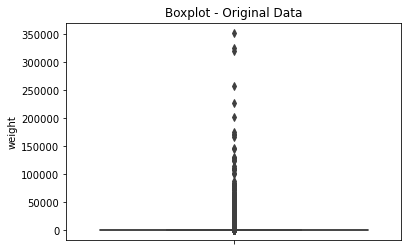

original data binned:
a.<10          3461
b.10-1K       75313
c.1K-5K       12509
d.5K-10K        921
e.10K-20K       380
f.20K-50K       188
g.50K-100K       37
h.+100K          25
Name: weight_bin, dtype: int64


df new shape:  (90647, 3)


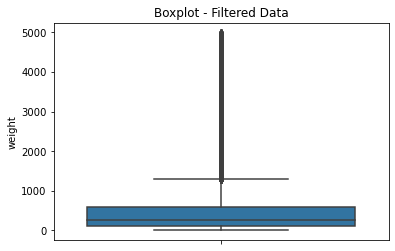

filtered data - stats:
count   90647.000
mean      503.311
std       694.295
min         2.000
25%       107.000
50%       256.000
75%       587.000
max      4991.000
Name: weight, dtype: float64


% of removed records: 0.0236
input data shape: (90647, 3)
unique artists:  17453
line divides top: 80.0 % cumulative sum of users:


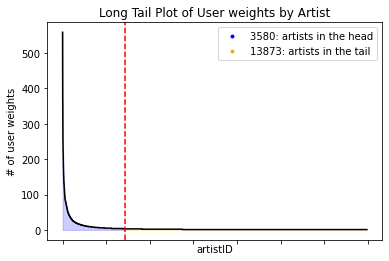

bottom 10 artists: 
1486        2009 Names in Vain
1487     Amsterdam Guitar Trio
9479                 Luz Casal
9483              Paul Gilbert
9485                Beth Ditto
9487           Johanna Kurkela
9488                     Birdy
9489                  Ensemble
9491             Diana Navarro
17631         Grzegorz Tomczak
Name: name, dtype: object


total removed artists: 15947


line divides top: 80.0 % cumulative sum of users:


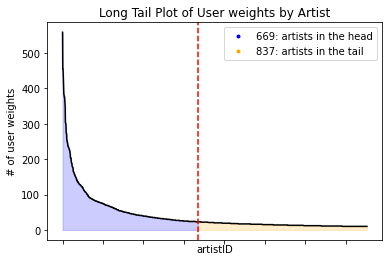

bottom 10 artists - filtered dataset: 
1092           These New Puritans
1729                      Soulwax
1914     ASIAN KUNG-FU GENERATION
2066                          Dev
2387                      Xiu Xiu
3975                     Morphine
4410                       Terror
4466                 Brooke Hogan
5177                        Swans
10639             Françoise Hardy
Name: name, dtype: object


filtered dataset shape: (61105, 3)
unique artists after removal:  1506
% of removed records: 0.3259


df original shape:  (61105, 3)
unique users:  1869
users with less than 10 artists: 86
unique users after removal:  1783
df new shape:  (60659, 3)
% of removed records: 0.0073


In [729]:
#Suppose we apply all the preprocessing steps. except for scaling
df_excl_extremes = remove_extreme_weights (users_artists_data,2,5000)
#df_excl_popular = remove_popular_artists (df_excl_extremes,artists_data,0.005)
df_excl_rare = remove_rare_artists (df_excl_extremes,artists_data,min_users = 10)
print('\n')
df_excl_users_low = remove_users_lowcount(df_excl_rare,10)
#df_scaled = scale_weight_by_user (df_excl_users_low)


In [730]:
#remove 2 artists per use for testing:
train, test = train_test_split(df_excl_users_low,sample_size=2,seed=2021)

input data shape: (60659, 3)
train set shape: (57093, 3)
test set shape: (3566, 3)


OK: all artists from the test set are part on the train set as well


In [720]:
#Sparse matrix, we need to pivot the data
data_pivot = train.pivot(index='userID',
                                       columns='artistID').fillna(0).astype(int)
data_pivot.head()

weight                                                        ...  \
artistID  2     6     7     8     9     10    11    12    13    15     ...   
userID                                                                 ...   
2             0     0     0     0     0     0     0     0     0     0  ...   
4             0     0     0     0     0     0     0     0     0     0  ...   
5             0     0     0     0     0     0     0     0     0     0  ...   
6             0     0     0     0     0     0     0     0     0     0  ...   
7             0     0     0     0     0     0     0     0     0     0  ...   

                                                                      
artistID 12406 12555 12599 12868 12918 13292 13303 13888 14645 14692  
userID                                                                
2            0     0     0     0     0     0     0     0     0     0  
4            0     0     0     0     0     0     0     0     0     0  
5            0     0     0     0     0     0     0     0     0     0  
6            0     0     0     0     0     0     0     0     0     0  
7            0     0     0     0     0     0     0     0     0     0  

[5 rows x 2797 columns]

In [721]:
#fit model = generate cosine matrix for the train set
cosine_matrix = similarity(data_pivot,kind='user')

In [754]:
#Basic Qualitative Testing using the matrix
user = np.random.choice(cosine_matrix.index)#pick a row from train matrix
n_neighbors = 5

table = cosine_matrix.reset_index()
user_row = table[table['userID']==user] #pick user row
user_row = user_row.iloc[: , 1:].transpose() #drop first column and transpose
user_row.columns=['distance']
user_row = user_row.sort_values(by='distance',ascending=False) #higher is closer

neighbors = list(user_row.head(n_neighbors+1).index)
distances = list(user_row['distance'].head(n_neighbors+1))

top_artists = get_top_artists(user,5)
print(f"Neighbors for user {user}\ntop 5: {top_artists}\n")

for i in range(1,n_neighbors+1):
        top_artists = get_top_artists(neighbors[i],5)
        print(f"{i}: User {neighbors[i]} \n distance {distances[i]}\n top artists: {top_artists}\n")

recommend_knn(user,n_neighbors,40)


Neighbors for user 979
top 5: ['Spice Girls', 'Fall Out Boy', "Slash's Snakepit", 'Rammstein', 'Lady Gaga']

1: User 756 
 distance 0.24901170377637602
 top artists: ['Portishead', 'The Doors', 'Pixies', 'Air', 'The Jesus and Mary Chain']

2: User 1964 
 distance 0.24451859935264547
 top artists: ['Dirty Projectors', 'Vampire Weekend', 'Smith Westerns', 'Frédéric Chopin', 'Telepathe']

3: User 2001 
 distance 0.2280450183387463
 top artists: ['Aborted', 'Finch', "Guns N' Roses", 'Superjoint Ritual', 'Rebel Meets Rebel']

4: User 109 
 distance 0.21506786684485632
 top artists: ['Mr. Big', 'Billy Idol', 'Scorpions', 'Motörhead', 'Def Leppard']

5: User 395 
 distance 0.21044682661820485
 top artists: ['Brain Forest Rytual', 'Dope', 'D.O.A.', 'Bogamber', 'Legion of the Damned']

computed scores:  2713
scores higher than 0:  140
scores for unknown artists:  135


,artistID,weight,name
19,518,538.232,Within Temptation
103,2381,527.124,Dethklok
85,1977,492.739,The Raconteurs
75,1673,419.000,Tokio Hotel
122,3244,403.216,Deathstars
97,2347,392.691,Van Halen
36,842,375.781,Despised Icon
63,1276,371.745,Immortal
31,786,356.383,Mandy Moore
91,2136,302.170,Serge Gainsbourg


In [ ]:
#using all users

In [756]:
recommend_knn(user,data_pivot.shape[0],100)

computed scores:  2713
scores higher than 0:  2713
scores for unknown artists:  2683


,artistID,weight,name
546,919,2121.373,Savatage
35,61,1754.596,Talk Talk
473,818,1691.347,36 Crazyfists
94,189,1623.617,Poets of the Fall
161,297,1589.952,David Cook
...,...,...,...
636,1051,695.183,Alesha Dixon
74,162,693.369,God Is an Astronaut
802,1364,691.209,Exodus
303,519,687.528,Static-X


## Clustering

In [ ]:
#problem #1 the rating(weight) has different scales depending on heavy and light users
#2 Distance metric
''' 
Selection of similarity metric
Some helpful cues while selecting similarity metric are-
·Use Pearson when your data is subject to user-bias/ different ratings scales of users
· Use Cosine, if data is sparse (many ratings are undefined)
· Use Euclidean, if your data is not sparse and the magnitude of the attribute values is significant
· Use adjusted cosine for Item-based approach to adjust for user-bias
'''

In [744]:
# Collaborative Filtering Using Nearest Neighbors

''' 
NearestNeighbors implements unsupervised nearest neighbors learning. 
It acts as a uniform interface to three different nearest neighbors algorithms: BallTree,
KDTree, and a brute-force algorithm based on routines in sklearn.metrics.pairwise. 
The choice of neighbors search algorithm is controlled through the keyword 'algorithm',
which must be one of ['auto', 'ball_tree', 'kd_tree', 'brute']. When the default value 'auto' 
is passed, the algorithm attempts to determine the best approach from the training data. 

If there are some significant overlap between the two sets, we'd like the function to return a real number 
that is closer one (ex: 0.95) and vice versa the most dissimilar two sets of items are we want the items 
to approximate zero (ex: 0.05). Fortunately the positive values of cosine exhibit this behavior:
Cosine(0)   = 1.0   # 0 degrees angle
Cosine(π/4) ≈ 0.7   # 45 degrees angle
Cosine(π/2) = 0.0   # 90 degrees angle
https://www.linkedin.com/pulse/cosine-similarity-classification-michael-lin/
''' 
from sklearn.neighbors import NearestNeighbors
#source: https://datascienceplus.com/building-a-book-recommender-system-the-basics-knn-and-matrix-factorization/
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
#brute computes all the distances instead of using a heuristic like KD-trees
#Euclidean distance is unhelpful in high dimensions because all vectors are 
#almost equidistant to the search query vector
model_knn.fit(data_pivot.values)
print(model_knn)

NearestNeighbors(algorithm='brute', metric='cosine')


In [745]:
#Basic Qualitative Testing using the matrix
query_index = np.random.choice(data_pivot.shape[0])#pick a row from matrix

#iloc selects by position
user_vector = data_pivot.iloc[query_index,:].values.reshape(1,-1) #take artist lists 
user = data_pivot.index[query_index]


n_neighbors = 5

distances, indices = model_knn.kneighbors(user_vector, n_neighbors = n_neighbors+1)
distances = distances.flatten()


top_artists = get_top_artists(user,5)
print(f"Neighbors for user {user}\ntop 5: {top_artists}\n")

for i in range(1,n_neighbors+1):
        neighbor = data_pivot.index[indices.flatten()[i]]
        top_artists = get_top_artists(neighbor,5)
        print(f"{i}: User {neighbor}\ndistance {distances[i]}\ntop 5: {top_artists}\n")




Neighbors for user 527
top 5: ['Willow Smith', 'Diddy - Dirty Money', 'Simon Curtis', 'Kerli', 'Noisettes']

1: User 1305
distance 0.4035614644052099
top 5: ['Kanye West', '4minute', 'Madonna', 'Aretha Franklin', 'Kelly Clarkson']

2: User 305
distance 0.44161749576327847
top 5: ['Wisin & Yandel', 'Coldplay', 'Eminem', 'Justin Timberlake', 'Jason Derülo']

3: User 2059
distance 0.5088867012154794
top 5: ['Bruno Mars', "Christina Aguilera, Lil' Kim, Mya & Pink", 'Anastacia', 'Kelly Clarkson', 'Keri Hilson']

4: User 1473
distance 0.5385724154628542
top 5: ['Black Kids', 'Jonas Brothers', 'Owl City', '宇多田ヒカル', 'Amy Winehouse']

5: User 318
distance 0.6056167852490673
top 5: ['Hilary Duff', 'Madonna', 'The Nitty Gritty Dirt Band', 'Alan Jackson', 'The Ting Tings']



In [ ]:
#reccomender implementation based on top n neighbors
user = 1513
n_neighbors = 5
user_vector = data_pivot[data_pivot.index == user].values.reshape(1,-1) 

distances, indices = model_knn.kneighbors(user_vector, n_neighbors = n_neighbors+1)
distances = distances.flatten()

for i in range(1,n_neighbors+1):
        neighbor = data_pivot.index[indices.flatten()[i]]
        top_artists = get_top_artists(neighbor,5)
        print(f"{i}: User {neighbor}\ndistance {distances[i]}\ntop 5: {top_artists}\n")



In [485]:
distances

array([0.        , 0.46106187, 0.68941604, 0.7195893 , 0.72171791,
       0.73782355])

In [ ]:
model_knn.

In [ ]:
model_knn.

In [422]:
query_index = np.random.choice(data_pivot.shape[0])#pick a row from matrix
user_vector = data_pivot.iloc[query_index,:].values.reshape(1,-1) #take artist lists 
user = data_pivot.index[query_index]

n_neighbors = 5

distances, indices = model_knn.kneighbors(user_vector, n_neighbors = 100)

In [419]:
data_pivot.index

Int64Index([   2,    4,    5,    6,    7,    8,    9,   10,   11,   12,
            ...
            2088, 2090, 2091, 2092, 2093, 2094, 2096, 2097, 2099, 2100],
           dtype='int64', name='userID', length=1810)

In [417]:
indices.flatten()

array([ 279, 1274, 1666, 1639,  135,  912,  454,  246,  103,  653,  722,
        963, 1002,  902, 1134,   70,  801,  476, 1476, 1053, 1213,  205,
          6,  786, 1522,  590,  954,  906,  605,  604, 1251,  301, 1177,
        485, 1750,  208,  610, 1781,  394,  877,  124, 1345, 1581, 1534,
        609,  732, 1698,  668, 1788, 1203,  738,  211,  450,  232, 1603,
        645,  556,  593, 1271,  787, 1564, 1377,  342,  771, 1569, 1237,
        121, 1793, 1633, 1553, 1683,  147,  920, 1511,  928,  457,  588,
        133,  880, 1640,  479, 1596,  855,  555, 1248,  362, 1333, 1192,
        345,  150,  611, 1530, 1519,  672, 1067, 1282, 1771, 1120, 1367,
        406])

In [16]:
#to Numpy
#data_pivot.to_numpy()
#data_pivot.shape

In [15]:
artists_model = artists_group[artists_group['scrobbles_sum']>=threshold]
#modify matrix
print('original shape: ',users_artists_data.shape)
filtered_artists = users_artists_data.merge(artists_model['artistID'],
                                               how = 'inner',
                                               left_on = 'artistID',
                                               right_on = 'artistID')

print('new shape: ',filtered_artists.shape)

#Sparse matrix, we need to pivot the data
data_pivot = filtered_artists.pivot(index='userID',
                                       columns='artistID').fillna(0).astype(int)

print('pivot shape: ',data_pivot.shape)


#Trying to make it more memory efficient
# create scipy sparse from pivot tables
data_sparse = sparse.csr_matrix(data_pivot)

original shape:  (92834, 3)
new shape:  (92013, 3)
pivot shape:  (1888, 16817)


In [116]:
#user top 10 artists
df_scrobbles[df_scrobbles['userID']==user].sort_values(by='scrobbles',ascending = False).head(10)  



,userID,artistID,scrobbles,name
2242,1505,72,13790,Depeche Mode
3844,1505,153,4964,De/Vision
27148,1505,518,2603,Within Temptation
53301,1505,1793,2206,Schiller
52593,1505,1713,1919,Dave Gahan
6968,1505,193,1682,Tears for Fears
89235,1505,15094,1524,Nerdette
20694,1505,378,1390,Evanescence
84845,1505,11529,1290,Sync24
41183,1505,1014,1119,Erasure


In [117]:
#closest neighbor top 10 artist
closest_neighbor = data_pivot.index[indices.flatten()[1]]
df_scrobbles[df_scrobbles['userID']==closest_neighbor].sort_values(by='scrobbles',ascending = False).head(10)  


,userID,artistID,scrobbles,name
2147,767,72,71852,Depeche Mode
42330,767,30,6316,And One
52578,767,1713,5741,Dave Gahan
6572,767,190,3257,Muse
5618,767,173,3144,Placebo
20618,767,378,1894,Evanescence
37427,767,880,1284,Nitzer Ebb
42503,767,1072,1274,Martin L. Gore
82399,767,9886,998,"Raz, Dwa, Trzy"
63863,767,3237,872,Hey


In [118]:
# 2nd closest neighbor top 10 artist
closest_neighbor = data_pivot.index[indices.flatten()[2]]
df_scrobbles[df_scrobbles['userID']==closest_neighbor].sort_values(by='scrobbles',ascending = False).head(10)  



,userID,artistID,scrobbles,name
2310,2080,72,80721,Depeche Mode
52602,2080,1713,6559,Dave Gahan
2531,2080,81,4869,Portishead
34685,2080,748,3384,Boards of Canada
208,2080,53,2087,Air
77997,2080,7470,1918,LFO
882,2080,59,1782,New Order
54428,2080,1893,1627,Yellow Magic Orchestra
74645,2080,6150,1313,Tangerine Dream
37435,2080,880,1226,Nitzer Ebb


In [ ]:
#Ok.... but how do we recommend an artist??



In [ ]:
#ok but what if I want the clusters and its info
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=200, random_state=0).fit(data_sparse)
kmeans.labels_

In [ ]:
#centroids
len(kmeans.cluster_centers_)

In [339]:
artist_df

NameError: name 'artist_df' is not defined